In [2]:
# Deskriptive Statistik
# mit Pandas und via_intermediary = 0

import operator
from dateutil import parser
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import pandas as pd
from matplotlib_venn import venn2, venn3

In [3]:
# Synonyme für PFP als Liste
pfp_gen = ['Pflegefachperson', 'Pflegefachfrau', 'Pflegefachmann', 'Pflegefachkraft']
pfp_kh =  ['Krankenschwester', 'Krankenpfleger', 'Krankenpflegefachperson']
pfp_ap = ['Altenpfleger', 'Altenpflegefachkraft', 'Altenpflegefachperson']
pfp_ki = ['Kinderkrankenschwester', 'Kinderkrankenpfleger', 'Kinderkrankenpflegefachperson'] 
# Die Bezeichnungen in pfp_ki entsprechen den Bezeichnungen in pfp_kh mit dem Zusatz "Kinder".
# Falls in pfp_ki eine Bezeichnung steht, die dieser Regel widerspricht, so wird diese nicht gezählt!!
# Außerdem muss pfp_ki[n] auch pfp_kh[n] entsprechen (jeweils mit/ohne Kinder-), sonst funktioniert der Zähler nicht (Z. 142f.)!
# Dieser Regel darf also nicht widersprochen werden!
# Weibliche Formen, die nur durch -in entstehen, werden nicht beachtet bzw. zählen zu den männlichen dazu

In [47]:
# Echte Daten
years = ['2016'] # Hier die Jahre angeben, die geladen werden sollen (final: 2016-2023)
count_gen_oza = {}
count_kh_oza = {}
count_ki_oza = {}
count_ap_oza = {}
count_all_oza = {}
count_kh_gen = {}
count_kh_ki = {}
count_kh_ap = {}
count_gen_ki = {}
count_gen_ap = {}
count_ki_ap = {}
count_kh_gen_ki = {}
count_kh_gen_ap = {}
count_kh_ki_ap = {}
count_gen_ki_ap = {}
count_gen_ki_ap_kh = {}
count_vars_unique = {}
count_einser = {}
count_zweier = {}
count_dreier = {}
total_count = {}
total_nan = {}
fehler = {}
month_counts = {}  # Speichert die Anzahl der Stellenanzeigen für jedes (Jahr, Monat)
all_months = set()
year_counts = {}  # Speichert die Anzahl der Stellenanzeigen für jedes Jahr
all_years = set()
for year in years:
    # Hier Jahr öffnen (json), filtern, Variablen rausholen, löschen
    with open(f"/Users/jan/Documents/Promotion/BIBB GW/hdd/Pflege/Pflege_{year}.json", 'r') as file:
        output = json.load(file)
    sorted_indices = sorted(output["date"], key=lambda i: output["date"][i])
    #df_full = pd.DataFrame(sorted_indices)
    df_full = pd.DataFrame({
        "date": [output["date"][i] for i in sorted_indices],
        "full_text": [output["full_text"][i] for i in sorted_indices],
        "via_intermediary": [output["via_intermediary"][i] for i in sorted_indices],
        "contract_type": [output["contract_type"][i] for i in sorted_indices]
    })
    del sorted_indices
    # Intermediarys rausfiltern
    df_full = df_full[df_full["via_intermediary"] != True]
    df_full['gen'] = pd.NA
    df_full['kh'] = pd.NA
    df_full['ki'] = pd.NA
    df_full['ap'] = pd.NA
    for i in range(len(pfp_gen)):
        result = df_full['full_text'].str.contains(pfp_gen[i], case=False, na=False)
        df_full.loc[result, 'gen'] = 1
    for i in range(len(pfp_kh)):
        result = df_full['full_text'].str.contains(rf'\b{pfp_kh[i]}', case=False, na=False)
        df_full.loc[result, 'kh'] = 1
    for i in range(len(pfp_ki)):
        result = df_full['full_text'].str.contains(pfp_ki[i], case=False, na=False)
        df_full.loc[result, 'ki'] = 1
    for i in range(len(pfp_ap)):
        result = df_full['full_text'].str.contains(pfp_ap[i], case=False, na=False)
        df_full.loc[result, 'ap'] = 1
    fehler[year] = (df_full['ki'].isna() & df_full['gen'].isna() & df_full['kh'].isna() & df_full['ap'].isna()).sum()
    print(f"NaN-Fehler in Jahr {year}: {fehler[year]}")
    count_gen_oza[year] = (df_full['gen'] == 1 & df_full['ap'].isna() & df_full['kh'].isna() & df_full['ki'].isna()).sum()
    count_kh_oza[year] = (df_full['kh'] == 1 & df_full['ap'].isna() & df_full['ki'].isna() & df_full['gen'].isna()).sum()
    count_ki_oza[year] = (df_full['ki'] == 1 & df_full['ap'].isna() & df_full['gen'].isna() & df_full['kh'].isna()).sum()
    count_ap_oza[year] = (df_full['ap'] == 1 & df_full['ki'].isna() & df_full['gen'].isna() & df_full['kh'].isna()).sum()
    count_all_oza[year] = len(df_full)
    print(f"Stellenanzeigen in {year} insgesamt: {count_all_oza[year]}")
    print(f"Stellenanzeigen in {year} nur mit generalistischen Berufsbezeichnungen: {count_gen_oza[year]}")
    print(f"Stellenanzeigen in {year} nur mit Berufsbezeichnungen der Akutpflege: {count_kh_oza[year]}")
    print(f"Stellenanzeigen in {year} nur mit Berufsbezeichnungen der Kinderkrankenpflege: {count_ki_oza[year]}")
    print(f"Stellenanzeigen in {year} nur mit Berufsbezeichnungen der Altenpflege: {count_ap_oza[year]}")
    print("\nJetzt filtern:")
    # Kombination von 'kh' und 'gen'
    count_kh_gen[year] = ((df_full['kh'] == 1) & (df_full['gen'] == 1) & df_full['ki'].isna() & df_full['ap'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit kh = 1 und gen = 1: {count_kh_gen[year]}")
    # Kombination von 'kh' und 'ki'
    count_kh_ki[year] = ((df_full['kh'] == 1) & (df_full['ki'] == 1) & df_full['gen'].isna() & df_full['ap'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit kh = 1 und ki = 1: {count_kh_ki[year]}")
    # Kombination von 'kh' und 'ap'
    count_kh_ap[year] = ((df_full['kh'] == 1) & (df_full['ap'] == 1) & df_full['ki'].isna() & df_full['gen'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit kh = 1 und ap = 1: {count_kh_ap[year]}")
    # Kombination von 'gen' und 'ki'
    count_gen_ki[year] = ((df_full['gen'] == 1) & (df_full['ki'] == 1) & df_full['kh'].isna() & df_full['ap'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit gen = 1 und ki = 1: {count_gen_ki[year]}")
    # Kombination von 'gen' und 'ap'
    count_gen_ap[year] = ((df_full['gen'] == 1) & (df_full['ap'] == 1) & df_full['ki'].isna() & df_full['kh'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit gen = 1 und ap = 1: {count_gen_ap[year]}")
    # Kombination von 'ki' und 'ap'
    count_ki_ap[year] = ((df_full['ki'] == 1) & (df_full['ap'] == 1) & df_full['gen'].isna() & df_full['kh'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit ki = 1 und ap = 1: {count_ki_ap[year]}")
    # Kombination von 'kh', 'gen' und 'ki'
    count_kh_gen_ki[year] = ((df_full['kh'] == 1) & (df_full['ki'] == 1) & (df_full['gen'] == 1) & df_full['ap'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit kh = 1, gen = 1 und ki = 1: {count_kh_gen_ki[year]}")
    # Kombination von 'kh', 'gen' und 'ap'
    count_kh_gen_ap[year] = ((df_full['kh'] == 1) & (df_full['gen'] == 1) & (df_full['ap'] == 1) & df_full['ki'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit kh = 1, gen = 1 und ap = 1: {count_kh_gen_ap[year]}")
    # Kombination von 'kh', 'ki' und 'ap'
    count_kh_ki_ap[year] = ((df_full['kh'] == 1) & (df_full['ki'] == 1) & (df_full['ap'] == 1) & df_full['gen'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit kh = 1, ki = 1 und ap = 1: {count_kh_ki_ap[year]}")
    # Kombination von 'gen', 'ki' und 'ap'
    count_gen_ki_ap[year] = ((df_full['gen'] == 1) & (df_full['ki'] == 1) & (df_full['ap'] == 1) & df_full['kh'].isna()).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit gen = 1, ki = 1 und ap = 1: {count_gen_ki_ap[year]}")
    # Kombination von 'gen', 'ki' und 'ap' und 'kh'
    count_gen_ki_ap_kh[year] = ((df_full['gen'] == 1) & (df_full['ki'] == 1) & (df_full['ap'] == 1) & (df_full['kh'] == 1)).sum()
    print(f"Anzahl der Einträge in Jahr {year} mit gen = 1, ki = 1, ap = 1 und kh = 1: {count_gen_ki_ap_kh[year]}")
    print("Check:")
    count_vars_unique[year] = [
        count_kh_gen[year],     # 'kh=1', 'gen=1'
        count_kh_ki[year],      # 'kh=1', 'ki=1'
        count_kh_ap[year],      # 'kh=1', 'ap=1'

        count_gen_ki[year],     # 'gen=1', 'ki=1'
        count_gen_ap[year],     # 'gen=1', 'ap=1'

        count_ki_ap[year]      # 'ki=1', 'ap=1'
    ]
    count_zweier[year] = sum(count_vars_unique[year])
    count_einser[year] = count_kh_oza[year]+ count_gen_oza[year]+count_ki_oza[year]+count_ap_oza[year]
    count_dreier[year] = count_kh_gen_ki[year]+count_kh_gen_ap[year]+count_kh_ki_ap[year]+count_gen_ki_ap[year]
    # Zeige die Gesamtsumme an
    print(f"Die Gesamtsumme aller 1er in Jahr {year}: {count_einser[year]}")
    print(f"Die Gesamtsumme aller 2er-kombis in Jahr {year}: {count_zweier[year]}")
    print(f"Die Gesamtsumme aller 3er-kombis in Jahr {year}: {count_dreier[year]}")
    print(f"Die Gesamtsumme der 4er-Kombi in Jahr {year}: {count_gen_ki_ap_kh[year]}")
    total_count[year] = count_einser[year]+count_zweier[year]+count_dreier[year]+count_gen_ki_ap_kh[year]
    total_nan[year] = total_count[year]+fehler[year]
    # Zeige die Summe an
    print(f"Die Gesamtsumme aller 1er, 2er, 3er-kombis + der 4er-kombi in Jahr {year} ist: {total_count[year]}")
    print(f"Die Gesamtsumme aller 1er, 2er, 3er-kombis + der 4er-kombi + NaN-Fehler in Jahr {year} ist: {total_nan[year]}")
    print(f"Stellenanzeigen insgesamt: {count_all_oza[year]} (Muss gleich sein wie zeile darüber!)")
    timestamps = [datetime.strptime(date, "%Y-%m-%d") for date in df_full["date"]]
    months = {(ts.year, ts.month) for ts in timestamps}
    all_months.update(months)
    all_years.add(year)
    year_counts[year] = year_counts.get(year, 0) + len(timestamps) 
    for ts in timestamps:
        key = (ts.year, ts.month)
        month_counts[key] = month_counts.get(key, 0) + 1
    del df_full

NaN-Fehler in Jahr 2016: 263
Stellenanzeigen in 2016 insgesamt: 46628
Stellenanzeigen in 2016 nur mit generalistischen Berufsbezeichnungen: 1439
Stellenanzeigen in 2016 nur mit Berufsbezeichnungen der Akutpflege: 12879
Stellenanzeigen in 2016 nur mit Berufsbezeichnungen der Kinderkrankenpflege: 1470
Stellenanzeigen in 2016 nur mit Berufsbezeichnungen der Altenpflege: 7046

Jetzt filtern:
Anzahl der Einträge in Jahr 2016 mit kh = 1 und gen = 1: 1256
Anzahl der Einträge in Jahr 2016 mit kh = 1 und ki = 1: 1845
Anzahl der Einträge in Jahr 2016 mit kh = 1 und ap = 1: 10050
Anzahl der Einträge in Jahr 2016 mit gen = 1 und ki = 1: 27
Anzahl der Einträge in Jahr 2016 mit gen = 1 und ap = 1: 1032
Anzahl der Einträge in Jahr 2016 mit ki = 1 und ap = 1: 87
Anzahl der Einträge in Jahr 2016 mit kh = 1, gen = 1 und ki = 1: 246
Anzahl der Einträge in Jahr 2016 mit kh = 1, gen = 1 und ap = 1: 4642
Anzahl der Einträge in Jahr 2016 mit kh = 1, ki = 1 und ap = 1: 2615
Anzahl der Einträge in Jahr 2016 mi

In [5]:
for year in years:
    # Erstelle eine Kreuztabelle mit den Variablen als Zeilen und Spalten
    crosstab_matrix = pd.DataFrame(index=['kh=1', 'gen=1', 'ki=1', 'ap=1'],
                                   columns=['kh=1', 'gen=1', 'ki=1', 'ap=1'], dtype=int)
    # Füge die Häufigkeiten basierend auf den Kombinationen hinzu
    crosstab_matrix.loc['kh=1', 'gen=1'] = count_kh_gen[year]
    crosstab_matrix.loc['kh=1', 'ki=1'] = count_kh_ki[year]
    crosstab_matrix.loc['kh=1', 'ap=1'] = count_kh_ap[year]
    crosstab_matrix.loc['kh=1', 'kh=1'] = count_kh_oza[year]

    crosstab_matrix.loc['gen=1', 'ki=1'] = count_gen_ki[year]
    crosstab_matrix.loc['gen=1', 'ap=1'] = count_gen_ap[year]
    crosstab_matrix.loc['gen=1', 'kh=1'] = count_kh_gen[year]
    crosstab_matrix.loc['gen=1', 'gen=1'] = count_gen_oza[year]

    crosstab_matrix.loc['ki=1', 'ap=1'] = count_ki_ap[year]
    crosstab_matrix.loc['ki=1', 'kh=1'] = count_kh_ki[year]
    crosstab_matrix.loc['ki=1', 'ki=1'] = count_ki_oza[year]
    crosstab_matrix.loc['ki=1', 'gen=1'] = count_gen_ki[year]

    crosstab_matrix.loc['ap=1', 'gen=1'] = count_gen_ap[year] 
    crosstab_matrix.loc['ap=1', 'ki=1'] = count_ki_ap[year]
    crosstab_matrix.loc['ap=1', 'ap=1'] = count_ap_oza[year]
    crosstab_matrix.loc['ap=1', 'kh=1'] = count_kh_ap[year]

    crosstab_matrix['Row Total'] = crosstab_matrix.sum(axis=1)
    crosstab_matrix.loc['Column Total'] = crosstab_matrix.sum(axis=0)
    # Zeige die Kreuztabelle an
    print(f"Kreuztabelle: Überschneidungen der Berufsbezeichnungen im Jahr {year}")
    print(crosstab_matrix)
    print("")

Kreuztabelle: Überschneidungen der Berufsbezeichnungen im Jahr 2016
                 kh=1   gen=1    ki=1     ap=1  Row Total
kh=1          12879.0  1256.0  1845.0  10050.0    26030.0
gen=1          1256.0  1439.0    27.0   1032.0     3754.0
ki=1           1845.0    27.0  1470.0     87.0     3429.0
ap=1          10050.0  1032.0    87.0   7046.0    18215.0
Column Total  26030.0  3754.0  3429.0  18215.0    51428.0



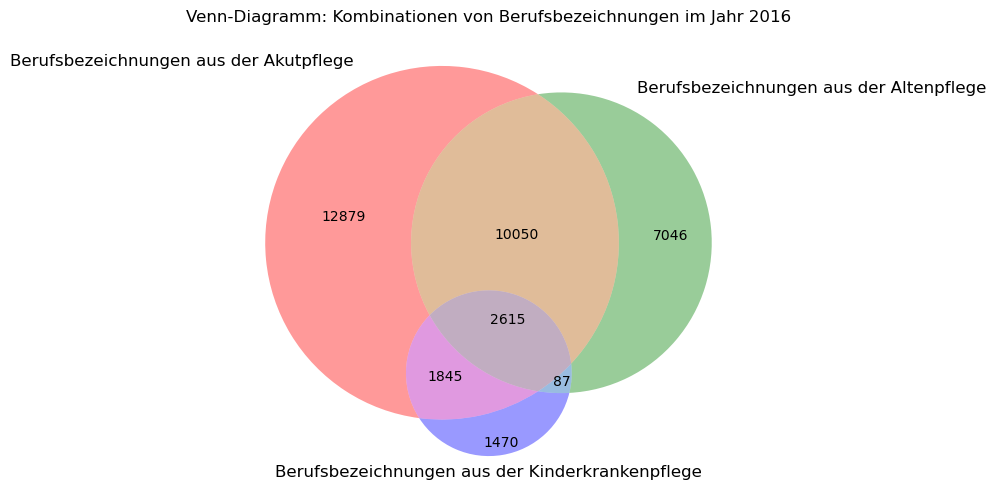

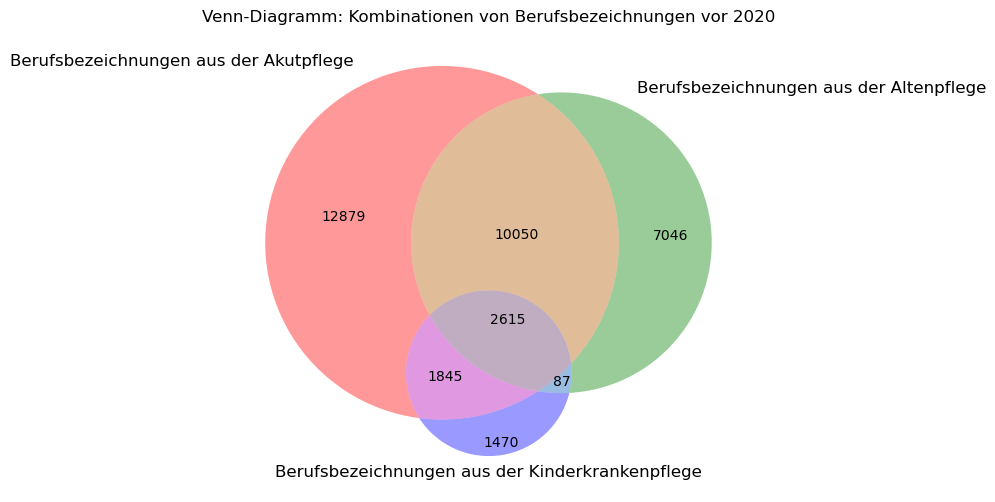

In [34]:
# Für alle Jahre + für pre-2020 + für post-2020 + einmal nur für 2023 (ab da gibts Generalisten)
# Zuerst Abfragen, welche Jahre in years-Liste sind!
count_kh_sub = 0
count_ap_sub = 0
count_kh_ki_sub = 0
count_ki_sub = 0
count_kh_ki_sub = 0
count_ki_ap_sub = 0
count_kh_ki_ap_sub = 0
count_kh_ap_sub = 0
count_kh_post = 0
count_ap_post = 0
count_kh_post_sub = 0
count_kh_gen_ki_sub = 0
count_kh_gen_ap_sub = 0
count_kh_ki_ap_sub = 0 
count_gen_ki_ap_sub = 0
count_gen_ki_ap_kh_sub = 0
count_all_oza_sub = 0

count_ki_post = 0
count_kh_ki_post = 0
count_ki_ap_post = 0
count_kh_ki_ap_post = 0
count_kh_ap_post = 0
count_gen_sub = 0
count_kh_gen_sub = 0
count_kh_ap_sub = 0
count_gen_ki_sub = 0
count_gen_ki_post = 0
count_gen_ap_sub = 0
count_gen_ap_post = 0
count_kh_gen_ki_post = 0
count_kh_gen_ap_post = 0
count_kh_ki_ap_post = 0 
count_gen_ki_ap_post = 0
count_gen_ki_ap_kh_post = 0
count_all_oza_post = 0
int_years = list(map(int, years))
for yearint in int_years:
    year = str(yearint)
    fig, ax = plt.subplots(figsize=(8, 6))  # Erstelle ein einzelnes Subplot
    venn3(
        subsets=(
            count_kh_oza[year],  # Nur kh
            count_ap_oza[year],  # Nur gen
            count_kh_ap[year],  # kh & gen
            count_ki_oza[year],  # Nur ki
            count_kh_ki[year],  # kh & ki
            count_ki_ap[year],  # gen & ki
            count_kh_ki_ap[year]  # kh & gen & ki
        ),
        set_labels=('Berufsbezeichnungen aus der Akutpflege', 'Berufsbezeichnungen aus der Altenpflege', 'Berufsbezeichnungen aus der Kinderkrankenpflege'),
        ax=ax  # Weisen wir das Diagramm dem Subplot zu
    )
    ax.set_title(f"Venn-Diagramm: Kombinationen von Berufsbezeichnungen im Jahr {year}")
    plt.show()
    if yearint < 2020:
        count_kh_sub += count_kh_oza[year]
        count_ap_sub += count_ap_oza[year]
        count_kh_ki_sub += count_kh_ki[year]
        count_ki_sub += count_ki_oza[year]
        count_ki_ap_sub += count_ki_ap[year]
        count_kh_ki_ap_sub += count_kh_ki_ap[year]
        count_kh_ap_sub += count_kh_ap[year]
        count_gen_sub += count_gen_oza[year]
        count_kh_gen_sub += count_kh_gen[year]
        count_gen_ki_sub += count_gen_ki[year]
        count_gen_ap_sub += count_gen_ap[year]
        count_kh_gen_ki_sub += count_kh_gen_ki[year] 
        count_kh_gen_ap_sub += count_kh_gen_ap[year] 
        count_gen_ki_ap_sub += count_gen_ki_ap[year] 
        count_gen_ki_ap_kh_sub += count_gen_ki_ap_kh[year]
        count_all_oza_sub += count_all_oza[year]
    if yearint >= 2020:
        count_kh_post += count_kh_oza[year]
        count_ap_post += count_ap_oza[year]
        count_ki_post += count_ki_oza[year]
        count_kh_ki_post += count_kh_ki[year]
        count_ki_ap_post += count_ki_ap[year]
        count_kh_ki_ap_post += count_kh_ki_ap[year]
        count_kh_ap_post += count_kh_ap[year]
        count_gen_post += count_gen_oza[year]
        count_kh_gen_post += count_kh_gen[year]
        count_gen_ki_post += count_gen_ki[year]
        count_gen_ap_post += count_gen_ap[year]
        count_kh_gen_ki_post += count_kh_gen_ki[year] 
        count_kh_gen_ap_post += count_kh_gen_ap[year] 
        count_gen_ki_ap_post += count_gen_ki_ap[year] 
        count_gen_ki_ap_kh_post += count_gen_ki_ap_kh[year]
        count_all_oza_post += count_all_oza[year]
if count_kh_sub >= 1:
    fig, ax = plt.subplots(figsize=(8, 6))  # Erstelle ein einzelnes Subplot
    venn3(
        subsets=(
            count_kh_sub,  # Nur kh
            count_ap_sub,  # Nur gen
            count_kh_ap_sub,  # kh & gen
            count_ki_sub,  # Nur ki
            count_kh_ki_sub,  # kh & ki
            count_ki_ap_sub,  # gen & ki
            count_kh_ki_ap_sub  # kh & gen & ki
        ),
        set_labels=('Berufsbezeichnungen aus der Akutpflege', 'Berufsbezeichnungen aus der Altenpflege', 'Berufsbezeichnungen aus der Kinderkrankenpflege'),
        ax=ax  # Weisen wir das Diagramm dem Subplot zu
    )
    ax.set_title("Venn-Diagramm: Kombinationen von Berufsbezeichnungen vor 2020")
    plt.show()
if count_kh_post >= 1:  
    fig, ax = plt.subplots(figsize=(8, 6))  # Erstelle ein einzelnes Subplot
    venn3(
        subsets=(
            count_kh_post,  # Nur kh
            count_ap_post,  # Nur gen
            count_kh_ap_post,  # kh & gen
            count_ki_post,  # Nur ki
            count_kh_ki_post,  # kh & ki
            count_ki_ap_post,  # gen & ki
            count_kh_ki_ap_post  # kh & gen & ki
        ),
        set_labels=('Berufsbezeichnungen aus der Akutpflege', 'Berufsbezeichnungen aus der Altenpflege', 'Berufsbezeichnungen aus der Kinderkrankenpflege'),
        ax=ax  # Weisen wir das Diagramm dem Subplot zu
    )
    ax.set_title("Venn-Diagramm: Kombinationen von Berufsbezeichnungen ab 2020")
    plt.show()

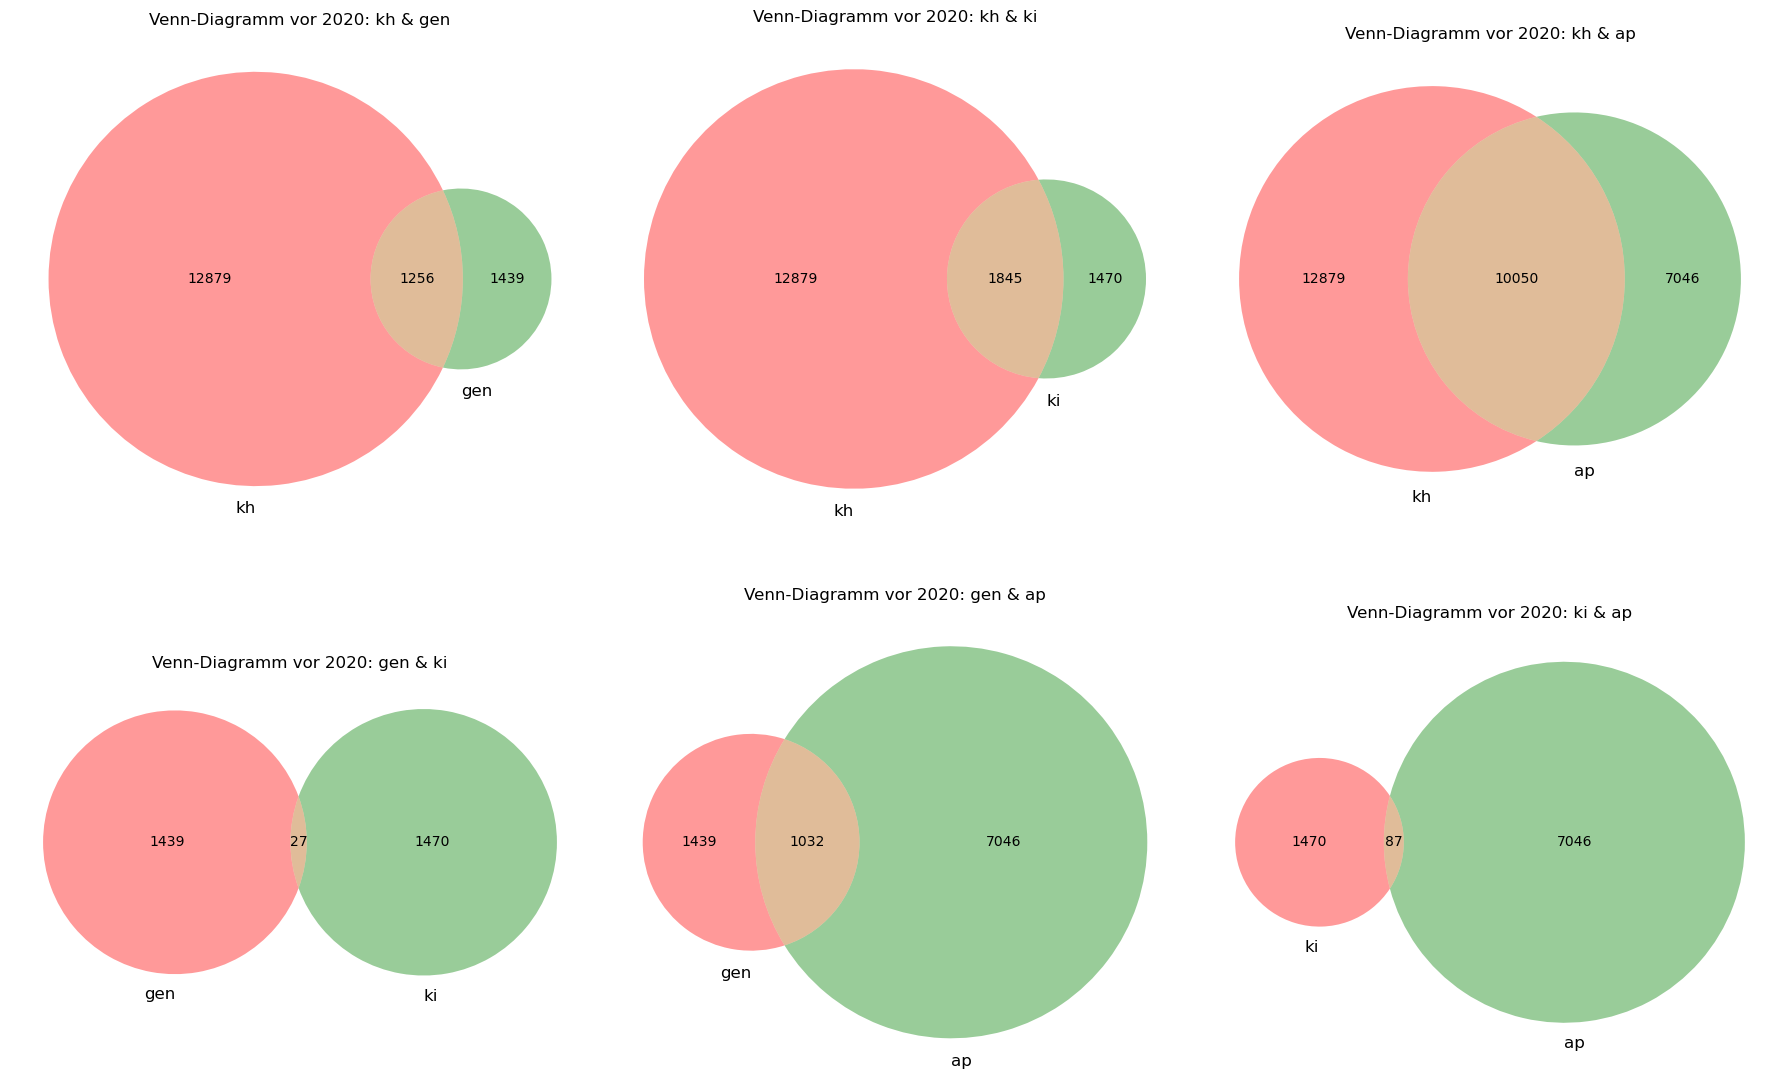

In [35]:
# für pre-2020 + für post-2020 + einmal nur für 2023 (ab da gibts Generalisten)
# Zuerst Abfragen, welche Jahre in years-Liste sind!
# Erstellen einer Figure mit 6 Subplots für die 2er-Kombinationen
if count_kh_sub >= 1:      
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    # Definition der 2er-Kombinationen und ihrer Werte
    combinations = [
        ("kh", "gen", count_kh_sub, count_gen_sub, count_kh_gen_sub),
        ("kh", "ki", count_kh_sub, count_ki_sub, count_kh_ki_sub),
        ("kh", "ap", count_kh_sub, count_ap_sub, count_kh_ap_sub),
        ("gen", "ki", count_gen_sub, count_ki_sub, count_gen_ki_sub),
        ("gen", "ap", count_gen_sub, count_ap_sub, count_gen_ap_sub),
        ("ki", "ap", count_ki_sub, count_ap_sub, count_ki_ap_sub)
    ]
    # Zeichnen der Venn-Diagramme
    for ax, (label1, label2, count1, count2, count_intersect) in zip(axes.flat, combinations):
        venn2(subsets=(count1, count2, count_intersect), set_labels=(label1, label2), ax=ax)
        ax.set_title(f"Venn-Diagramm vor 2020: {label1} & {label2}")
    plt.tight_layout()
    plt.show()
if count_kh_post >= 1: 
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    # Definition der 2er-Kombinationen und ihrer Werte
    combinations = [
        ("kh", "gen", count_kh_post, count_gen_post, count_kh_gen_post),
        ("kh", "ki", count_kh_post, count_ki_post, count_kh_ki_post),
        ("kh", "ap", count_kh_post, count_ap_post, count_kh_ap_post),
        ("gen", "ki", count_gen_post, count_ki_post, count_gen_ki_post),
        ("gen", "ap", count_gen_post, count_ap_post, count_gen_ap_post),
        ("ki", "ap", count_ki_post, count_ap_post, count_ki_ap_post)
    ]
    # Zeichnen der Venn-Diagramme
    for ax, (label1, label2, count1, count2, count_intersect) in zip(axes.flat, combinations):
        venn2(subsets=(count1, count2, count_intersect), set_labels=(label1, label2), ax=ax)
        ax.set_title(f"Venn-Diagramm ab 2020: {label1} & {label2}")
    plt.tight_layout()
    plt.show()
if "2023" in years:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    # Definition der 2er-Kombinationen und ihrer Werte
    combinations = [
        ("kh", "gen", count_kh["2023"], count_gen["2023"], count_kh_gen["2023"]),
        ("kh", "ki", count_kh["2023"], count_ki["2023"], count_kh_ki["2023"]),
        ("kh", "ap", count_kh["2023"], count_ap["2023"], count_kh_ap["2023"]),
        ("gen", "ki", count_gen["2023"], count_ki["2023"], count_gen_ki["2023"]),
        ("gen", "ap", count_gen["2023"], count_ap["2023"], count_gen_ap["2023"]),
        ("ki", "ap", count_ki["2023"], count_ap["2023"], count_ki_ap["2023"])
    ]
    # Zeichnen der Venn-Diagramme
    for ax, (label1, label2, count1, count2, count_intersect) in zip(axes.flat, combinations):
        venn2(subsets=(count1, count2, count_intersect), set_labels=(label1, label2), ax=ax)
        ax.set_title(f"Venn-Diagramm nur 2023: {label1} & {label2}")
    plt.tight_layout()
    plt.show()

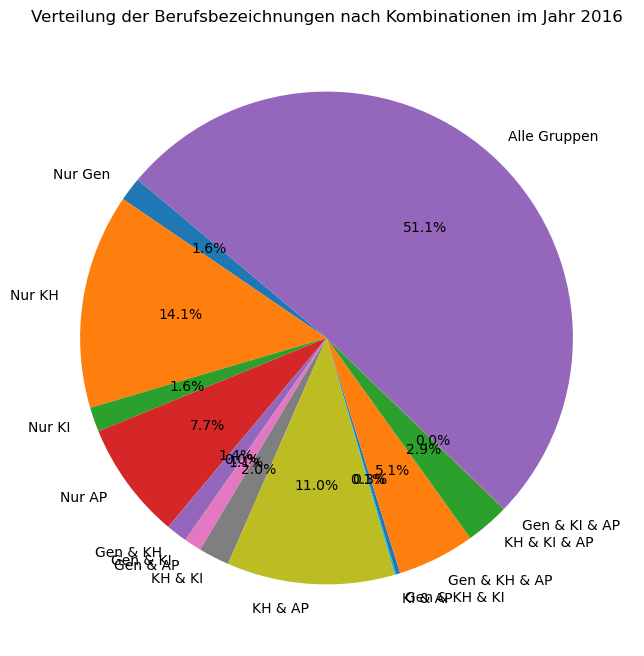

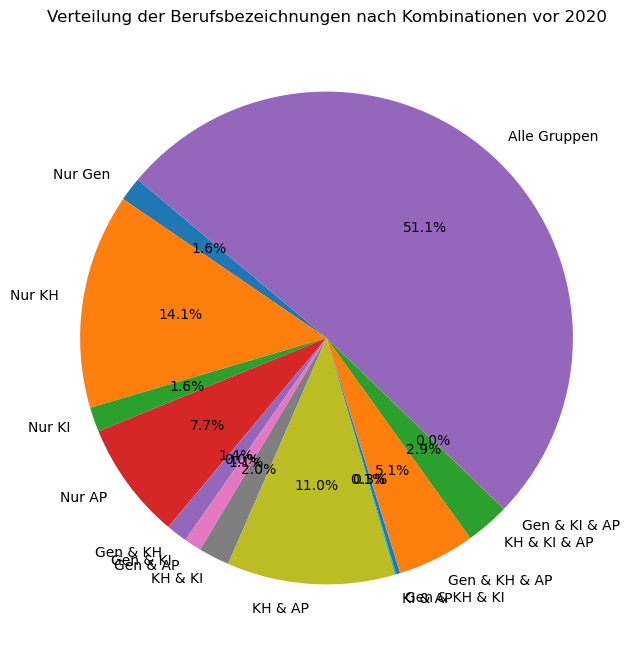

In [36]:
# Für alle Jahre + für pre-2020 + für post-2020 + einmal nur für 2023 (ab da gibts Generalisten)
# Zuerst Abfragen, welche Jahre in years-Liste sind!
# Werte für die vier Hauptkategorien und ihre Kombinationen
int_years = list(map(int, years))
for yearint in int_years:
    year = str(yearint)
    sizes = [
        count_gen_oza[year], count_kh_oza[year], count_ki_oza[year], count_ap_oza[year], 
        count_kh_gen[year], count_gen_ki[year], count_gen_ap[year], count_kh_ki[year], count_kh_ap[year], count_ki_ap[year], 
        count_kh_gen_ki[year], count_kh_gen_ap[year], count_kh_ki_ap[year], count_gen_ki_ap[year], count_all_oza[year]
    ]
    # Labels für das Diagramm
    labels = [
        "Nur Gen", "Nur KH", "Nur KI", "Nur AP",
        "Gen & KH", "Gen & KI", "Gen & AP", "KH & KI", "KH & AP", "KI & AP",
        "Gen & KH & KI", "Gen & KH & AP", "KH & KI & AP", "Gen & KI & AP", "Alle Gruppen"
    ]
    # Entferne Einträge mit Wert 0 für bessere Lesbarkeit
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [label for size, label in zip(sizes, labels) if size > 0]
    # Erstelle das Tortendiagramm
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
    # Titel setzen
    ax.set_title(f"Verteilung der Berufsbezeichnungen nach Kombinationen im Jahr {year}")
    # Zeige das Diagramm
    plt.show()
if count_kh_sub >= 1:  
    sizes = [
        count_gen_sub, count_kh_sub, count_ki_sub, count_ap_sub, 
        count_kh_gen_sub, count_gen_ki_sub, count_gen_ap_sub, count_kh_ki_sub, count_kh_ap_sub, count_ki_ap_sub, 
        count_kh_gen_ki_sub, count_kh_gen_ap_sub, count_kh_ki_ap_sub, count_gen_ki_ap_sub, count_all_oza_sub
    ]
    # Labels für das Diagramm
    labels = [
        "Nur Gen", "Nur KH", "Nur KI", "Nur AP",
        "Gen & KH", "Gen & KI", "Gen & AP", "KH & KI", "KH & AP", "KI & AP",
        "Gen & KH & KI", "Gen & KH & AP", "KH & KI & AP", "Gen & KI & AP", "Alle Gruppen"
    ]
    # Entferne Einträge mit Wert 0 für bessere Lesbarkeit
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [label for size, label in zip(sizes, labels) if size > 0]
    # Erstelle das Tortendiagramm
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
    # Titel setzen
    ax.set_title(f"Verteilung der Berufsbezeichnungen nach Kombinationen vor 2020")
    # Zeige das Diagramm
    plt.show()

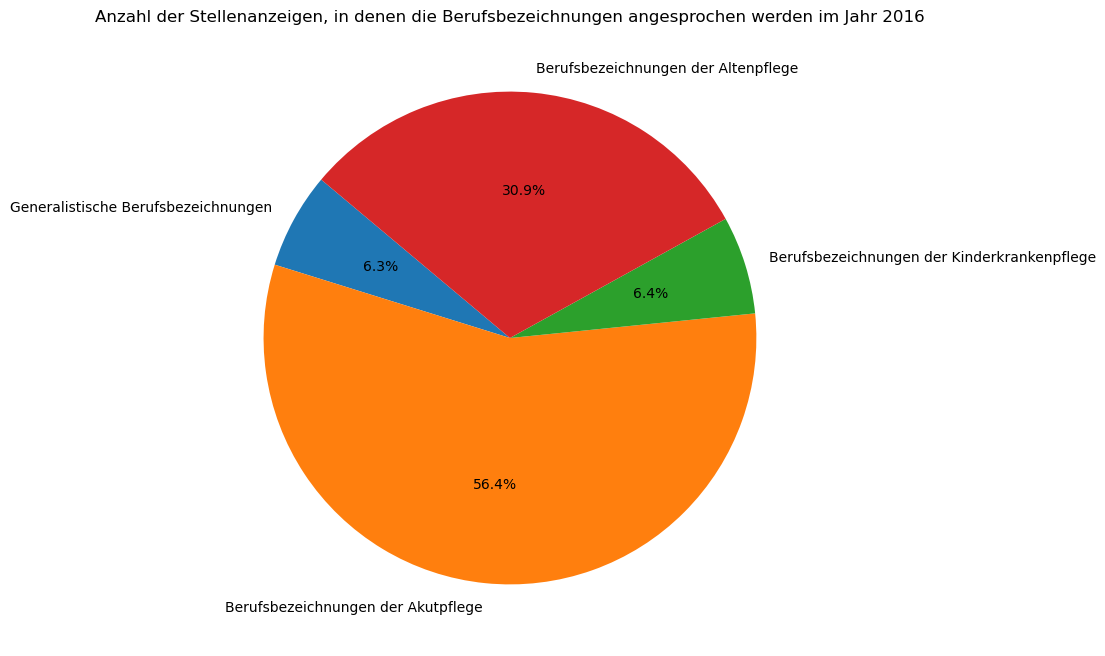

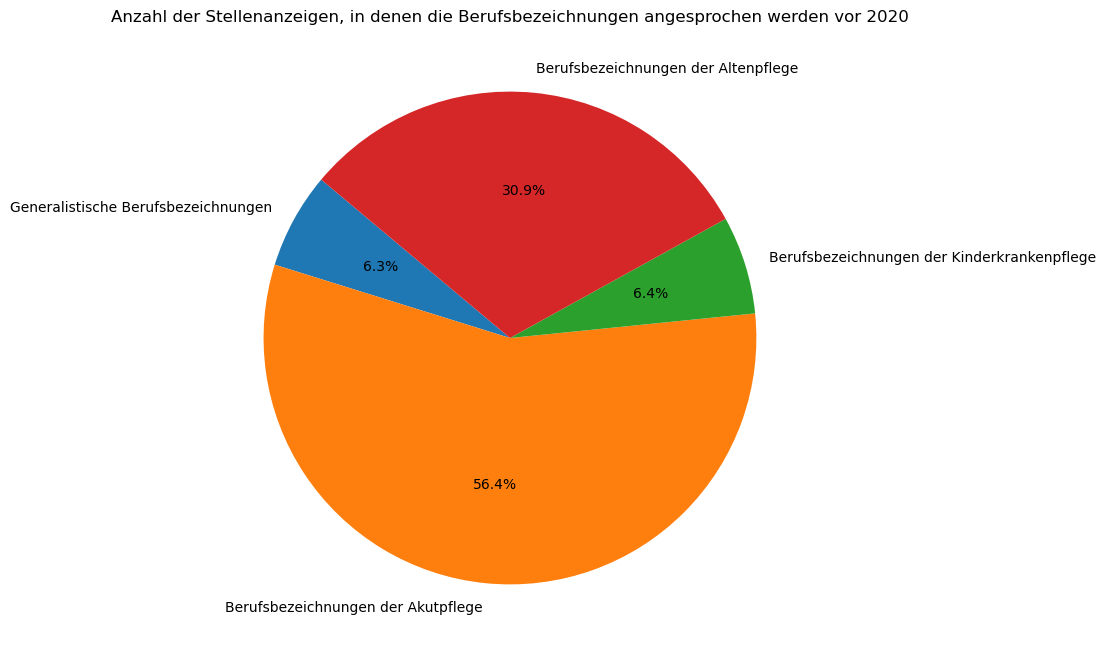

In [41]:
# Für alle Jahre
# Zuerst Abfragen, welche Jahre in years-Liste sind!
# Torte: gen_oza / kh_oza / ki_oza / ap_oza
int_years = list(map(int, years))
for yearint in int_years:
    year = str(yearint)
    sizes = [count_gen_oza[year], count_kh_oza[year], count_ki_oza[year], count_ap_oza[year]]
    # Labels für das Diagramm
    labels = ["Generalistische Berufsbezeichnungen", "Berufsbezeichnungen der Akutpflege", "Berufsbezeichnungen der Kinderkrankenpflege", "Berufsbezeichnungen der Altenpflege"]
    # Entferne Einträge mit Wert 0 für bessere Lesbarkeit
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [label for size, label in zip(sizes, labels) if size > 0]
    # Erstelle das Tortendiagramm
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
    # Titel setzen
    ax.set_title(f"Anzahl der Stellenanzeigen, in denen die Berufsbezeichnungen angesprochen werden im Jahr {year}")
    # Zeige das Diagramm
    plt.show()
if count_kh_sub >= 1:
    year = str(yearint)
    sizes = [count_gen_sub, count_kh_sub, count_ki_sub, count_ap_sub]
    # Labels für das Diagramm
    labels = ["Generalistische Berufsbezeichnungen", "Berufsbezeichnungen der Akutpflege", "Berufsbezeichnungen der Kinderkrankenpflege", "Berufsbezeichnungen der Altenpflege"]
    # Entferne Einträge mit Wert 0 für bessere Lesbarkeit
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [label for size, label in zip(sizes, labels) if size > 0]
    # Erstelle das Tortendiagramm
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
    # Titel setzen
    ax.set_title("Anzahl der Stellenanzeigen, in denen die Berufsbezeichnungen angesprochen werden vor 2020")
    # Zeige das Diagramm
    plt.show()
if count_kh_post >= 1:
    year = str(yearint)
    sizes = [count_gen_post, count_kh_post, count_ki_post, count_ap_post]
    # Labels für das Diagramm
    labels = ["Generalistische Berufsbezeichnungen", "Berufsbezeichnungen der Akutpflege", "Berufsbezeichnungen der Kinderkrankenpflege", "Berufsbezeichnungen der Altenpflege"]
    # Entferne Einträge mit Wert 0 für bessere Lesbarkeit
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [label for size, label in zip(sizes, labels) if size > 0]
    # Erstelle das Tortendiagramm
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
    # Titel setzen
    ax.set_title("Anzahl der Stellenanzeigen, in denen die Berufsbezeichnungen angesprochen werden vor 2020")
    # Zeige das Diagramm
    plt.show()

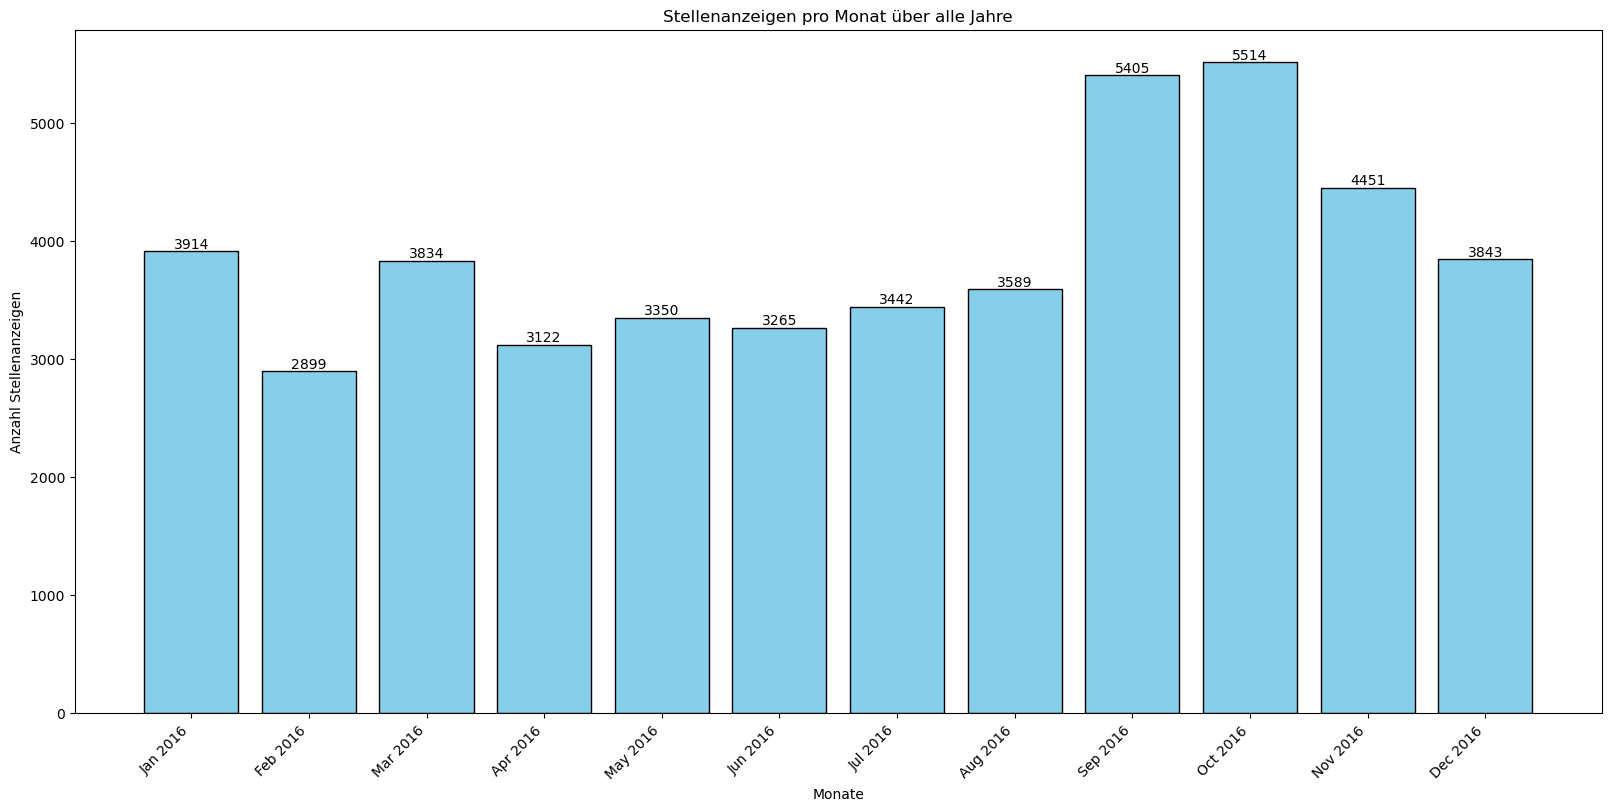

In [48]:
# Bar: Alle SteA pro Monat --> absolut
# Für alle Jahre
sorted_months = sorted(all_months)
month_labels = [datetime(year, month, 1).strftime("%b %Y") for year, month in sorted_months]
xmonths = np.arange(len(month_labels))
ymonths = [month_counts.get(month, 0) for month in sorted_months]
# Erstelle das finale Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
barone = ax.bar(xmonths, ymonths, color='skyblue', edgecolor='black')
# Werte über die Balken schreiben
for rect in barone:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(height), 
            ha='center', va='bottom')
# Achsenbeschriftung & Titel
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45, ha='right')
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Monat über alle Jahre')

# Zeige das Diagramm an
plt.show()

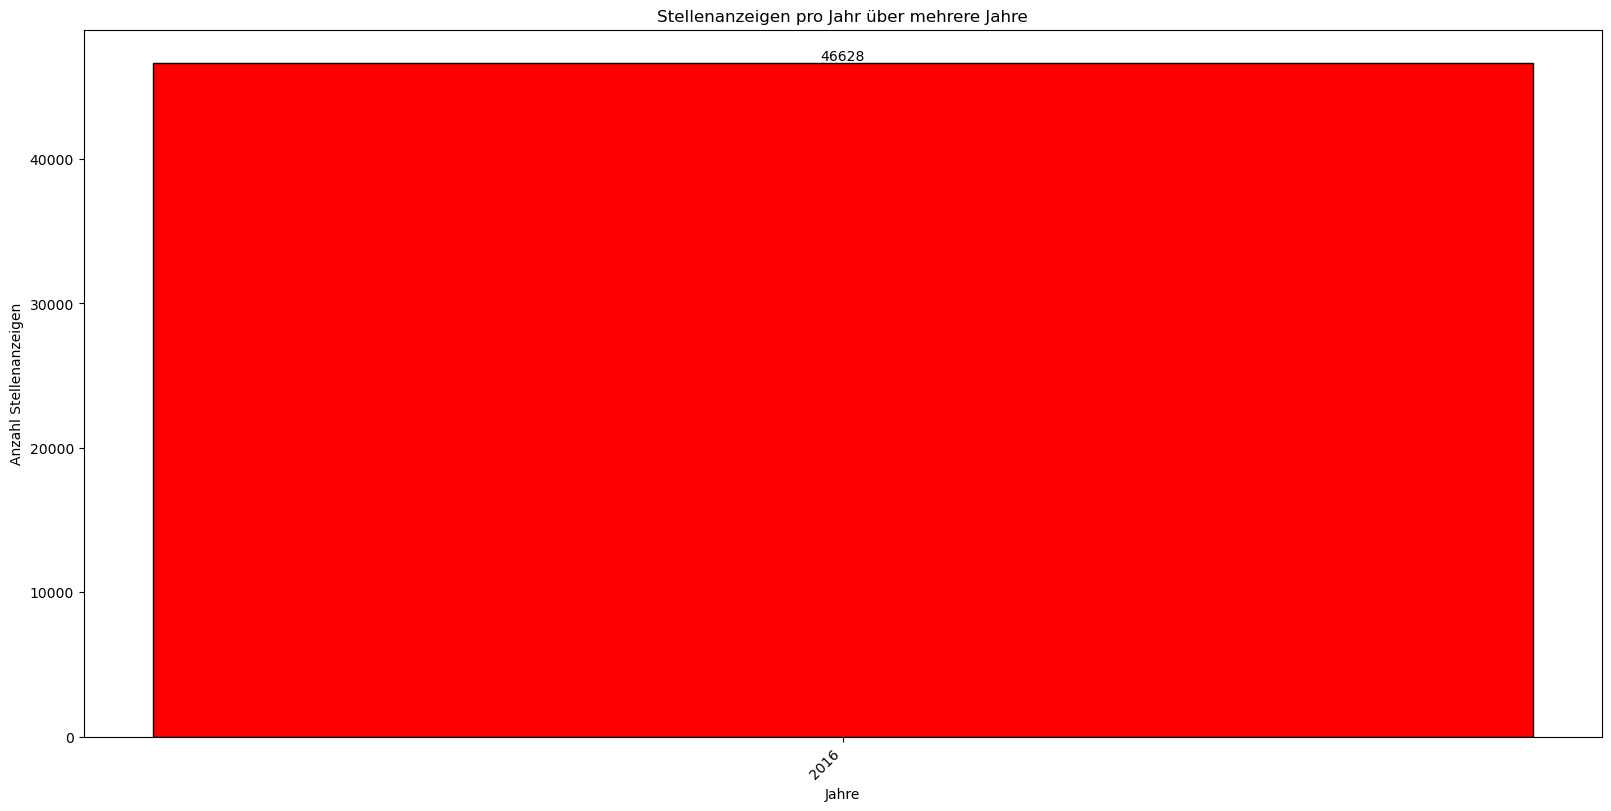

In [53]:
# Bar: Alle SteA pro Jahr absolut
bar_colors = ["red", "blue", "green", "orange", "purple", "cyan", "brown", "pink", "lime", "yellow"]
xyears = np.arange(len(sorted_years))
yyears = [year_counts.get(year, 0) for year in sorted_years]  # Fehlende Jahre = 0

# Erstelle das Balkendiagramm für die Jahresaggregation
fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
bartwo = ax.bar(xyears, yyears, color=bar_colors, edgecolor='black')

# Werte über die Balken schreiben
for rect in bartwo:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(height), 
            ha='center', va='bottom')

# Achsenbeschriftung & Titel
ax.set_xticks(xyears)
ax.set_xticklabels(sorted_years, rotation=45, ha='right')
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Jahr über mehrere Jahre')

# Zeige das Diagramm an
plt.show()

In [ ]:
# Genauere Betracht nur von den count_x_oza Werten --> diese sprechen die einzelne Gruppe x an, auch wenn andere
# Gruppen ebenfalls in der SteA genannt werden, so richtet sich diese doch auf jeden Fall an Gruppe X
#
# ToDo:
# Bar: SteA pro Jahr nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> absolut
# Bar: SteA pro Jahr nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> relativ
# Kurve: SteA pro Jahr nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> absolut
# Kurve: SteA pro Jahr nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> relativ
# Bar: SteA pro Monat nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> absolut
# Bar: SteA pro Monat nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> releativ
# Kurve: SteA pro Monat nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> absolut
# Kurve: SteA pro Monat nach Gruppe (alle SteA pro Gruppe --> mit Überschneidungen zu anderen Gruppen) --> relativ

# Wenn mehrere Jahre importiert werden:
# Mehrere Jahre können nicht importiert werden --> zu groß
# Ideen:
# * Notwendige Zahlen aus einem Jahr extrahieren, dann geladene Daten löschen (del) und das nächste Jahr laden
#
# Bar + Kurve: SteA in jedem Jahr insgesamt --> absolut + relativ
# Bar + Kurve: SteA in jedem Monat (über alle Jahre) insgesamt --> absolut + relativ
# Bar + Kurve: Stea in jedem Jahr nach Gruppe --> absolut + relativ
# Bar + Kurve: SteA in jedem Monat (über alle Jahre hinweg) nach Gruppe --> absolut + relativ
# Torte: Alle SteA in allen Jahren Anteile der Gruppen
# Torte + Venn: Überschneidungen pro Jahr --> oben for-schleife einbauen!

# Hochschulisch qualifizierte rausfiltern und darstellen